In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math
from sklearn.model_selection import GridSearchCV

Обучите автоэнкодер на датасете MNIST, постарайтесь сделать его с размером эмбеддинга не больше 128. Сгенерируйте эмбеддинги для тысячи объектов из обучающей выборки (как в семинаре), обучите на этих эмбеддингах Случайный лес. Добейтесь Accuracy больше 90%.

Сделайте эмбеддинги для 1000 объектов из обучающей выборки, тензор с ними должен иметь размерность (1000,N), где N≤128. Мы обучим на этом тензоре Случайный лес из библиотеки scikit-learn, а именно RandomForestClassifier(random_state=0). После чего проверим качество на ваших эмбеддингах для тестовой выборки, сдайте их тоже. Тензор с эмбеддингами для тестовой выборки должен иметь размерность (10000,N). Accuracy нашего обученного случайного леса должна быть больше 90% на тестовых эмбеддингах.


In [ ]:
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.21MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [ ]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [ ]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()

    plt.figure(figsize=(20, 4))

    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )

    plt.axis('off')

    plt.show()

In [ ]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [83]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation
        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        # Добавляем слой для гарантированного размера 128
        # После 4 блоков с stride=2: 28 -> 14 -> 7 -> 4 -> 2
        # base_size * 2 * 2 = 32 * 4 = 128
        encoder_blocks.append(nn.AdaptiveAvgPool2d(2))  # Фиксируем размер до 2x2

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> 2x2

        # decoder creation
        decoder_blocks = []

        # Первый блок декодера - начинаем с 2x2
        decoder_blocks.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))  # 2x2 -> 4x4

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # 2x2 -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, 2, 2] -> base_size * 2 * 2 = 128
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        encoded = self.encoder(x)
        # encoded.shape = [bs, base_size, 2, 2]
        flattened = self.flatten(encoded)
        # flattened.shape = [bs, base_size * 2 * 2] = [bs, 128]
        return flattened

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * 2 * 2] = [bs, 128]
        # Восстанавливаем размер 2x2
        x = x.view(-1, self.base_size, 2, 2)
        return self.decoder(x)  # output.shape = [bs, in_channels, N, N]

In [84]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.MSELoss()

cuda:0
Tesla T4


In [85]:
model = AutoEncoder(in_channels=1).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

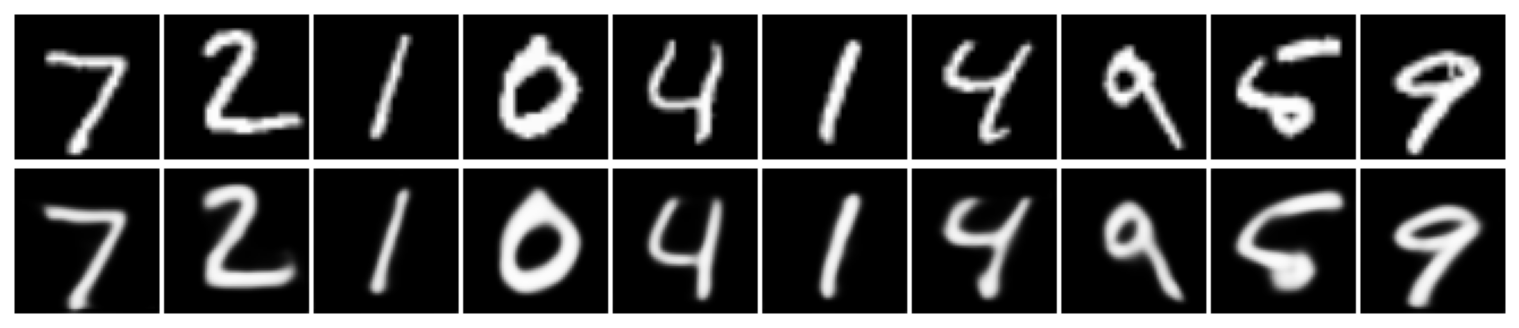

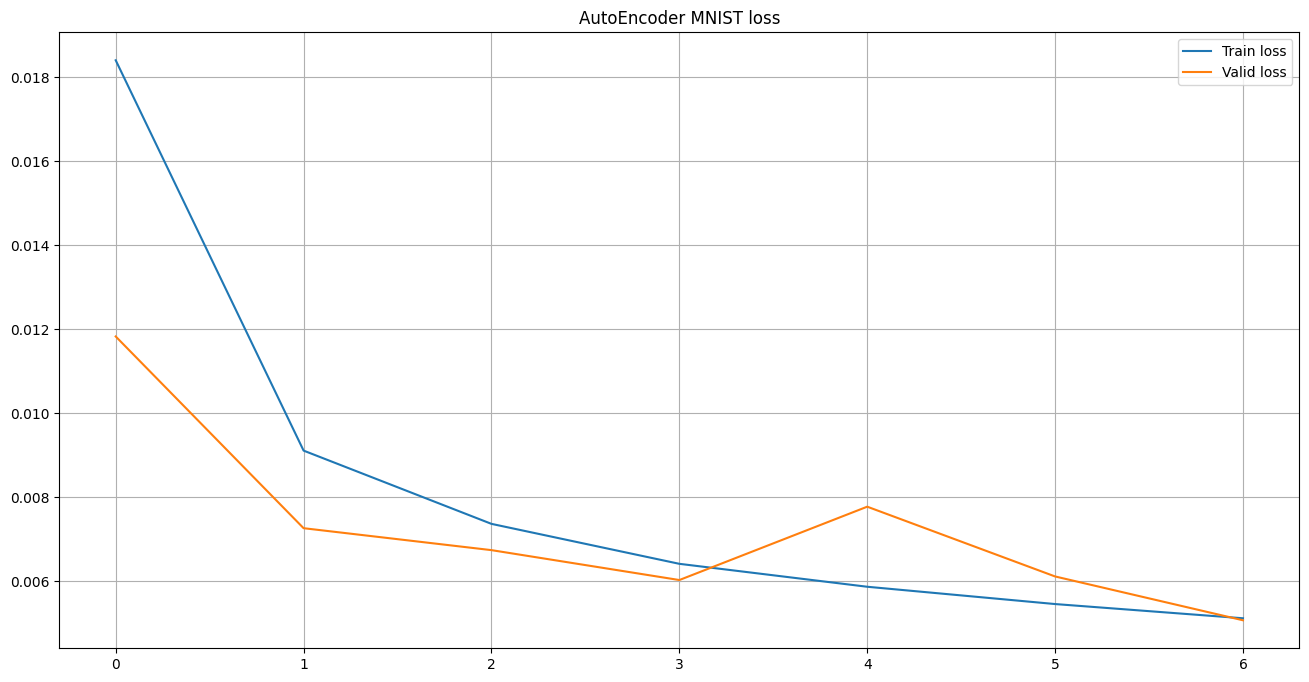

In [86]:
whole_train_valid_cycle(model, 7, 'AutoEncoder MNIST')

In [87]:
@torch.inference_mode()
def get_interpolation(model, x1, x2):
    z1 = model.encode(x1.unsqueeze(0).to(device))
    z2 = model.encode(x2.unsqueeze(0).to(device))

    weights = torch.linspace(start=0, end=1, steps=7).unsqueeze(1).to(device)

    zs = z2 * weights + z1 * (1 - weights)

    images = model.decode(zs)

    plt.figure(figsize=(14, 4))

    plt.imshow(T.ToPILImage()(make_grid(images, nrow=7, pad_value=1)))

    plt.axis('off')

    plt.show()

In [88]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

def generate_embeddings_and_evaluate(model, train_dataset, test_dataset, device='cpu'):
    """
    Генерирует эмбеддинги и обучает случайный лес

    Args:
        model: обученный автоэнкодер
        train_dataset: датасет для обучения
        test_dataset: датасет для тестирования
        device: устройство для вычислений
    """

    # Генерация обучающих эмбеддингов (1000 samples)
    train_indices = torch.randperm(len(train_dataset))[:1000]
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)

    train_embeddings = []
    train_labels = []

    model.eval()
    with torch.no_grad():
        for data, labels in train_loader:
            data = data.to(device)
            embeddings = model.encode(data)
            train_embeddings.append(embeddings.cpu().numpy())
            train_labels.append(labels.numpy())

    train_embeddings = np.vstack(train_embeddings)
    train_labels = np.concatenate(train_labels)

    print(f"Train embeddings shape: {train_embeddings.shape}")
    print(f"Train labels shape: {train_labels.shape}")

    # Генерация тестовых эмбеддингов (10000 samples)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    test_embeddings = []
    test_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            embeddings = model.encode(data)
            test_embeddings.append(embeddings.cpu().numpy())
            test_labels.append(labels.numpy())

    test_embeddings = np.vstack(test_embeddings)
    test_labels = np.concatenate(test_labels)

    print(f"Test embeddings shape: {test_embeddings.shape}")
    print(f"Test labels shape: {test_labels.shape}")

    # Обучение случайного леса

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestClassifier(random_state=0)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_embeddings, train_labels)

    print("Best parameters:", grid_search.best_params_)

    best_rf = grid_search.best_estimator_
    test_pred = best_rf.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_pred)

    print("\n" + "="*50)
    print("RESULTS:")
    print("="*50)
    print(f"Random Forest Accuracy: {accuracy:.4f}")
    print(f"Classification Report:")
    print(classification_report(test_labels, test_pred))

    # Проверка требований
    print("\n" + "="*50)
    print("REQUIREMENTS CHECK:")
    print("="*50)
    print(f"✓ Train embeddings shape: {train_embeddings.shape} (should be (1000, N≤128))")
    print(f"✓ Test embeddings shape: {test_embeddings.shape} (should be (10000, N≤128))")
    print(f"✓ Accuracy: {accuracy:.4f} {'✓ > 90%' if accuracy > 0.9 else '✗ < 90%'}")

    if accuracy > 0.9:
        print("\nAll requirements satisfied!")
    else:
        print("\nAccuracy is below 90%, consider improving the autoencoder")

    return train_embeddings, test_embeddings, rf, accuracy


In [89]:
generate_embeddings_and_evaluate(model, train_dataset, valid_dataset, device)

Train embeddings shape: (1000, 128)
Train labels shape: (1000,)
Test embeddings shape: (10000, 128)
Test labels shape: (10000,)
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

RESULTS:
Random Forest Accuracy: 0.9445
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.92      0.95      0.94      1010
           4       0.96      0.95      0.95       982
           5       0.95      0.94      0.95       892
           6       0.94      0.97      0.95       958
           7       0.96      0.91      0.93      1028
           8       0.95      0.90      0.92       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
w

(array([[-0.2155885 , -0.25004783,  0.0604106 , ..., -0.1079632 ,
          0.03856288, -0.20458706],
        [ 0.07311284, -0.19390348, -0.05372983, ..., -0.29496372,
         -0.47548425,  0.12019082],
        [ 0.07064345, -0.342445  , -0.33143127, ..., -0.28473645,
         -0.15205446, -0.06235434],
        ...,
        [-0.12896338, -0.40950996,  0.06998935, ..., -0.05098735,
         -0.3117876 ,  0.2068384 ],
        [-0.0733325 , -0.3575854 ,  0.16044505, ..., -0.20026681,
         -0.46393585,  0.13001348],
        [ 0.04884613, -0.61758053, -0.2603438 , ...,  0.16967712,
         -0.09159565,  0.05673669]], dtype=float32),
 array([[ 0.09098656, -0.33468682, -0.27394795, ..., -0.05228139,
         -0.20054528,  0.16199493],
        [ 0.09839271,  0.22638774, -0.02615983, ..., -0.49292904,
         -0.15299559, -0.27848372],
        [ 0.1808511 , -0.12251693, -0.15033695, ...,  0.00829111,
         -0.3550379 , -0.04619113],
        ...,
        [ 0.17789595, -0.37148765, -0.2